In [1]:
# Example sketch
import sys
# Allow notebooks to import project modules
from pathlib import Path

def _resolve_project_root():
    candidates = []
    try:
        candidates.append(Path.cwd().resolve())
    except FileNotFoundError:
        candidates.append(None)
    if "__file__" in globals():
        candidates.append(Path(__file__).resolve().parent)
    candidates.append(Path("/home/bram/work/PE-LiNN/pelinn-qem"))

    for base in candidates:
        if base is None:
            continue
        if (base / "pelinn").exists():
            return base
        parent = base.parent
        if (parent / "pelinn").exists():
            return parent
    return candidates[-1]

project_root = _resolve_project_root()
if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
import torch, numpy as np, random
from torch.utils.data import Dataset, DataLoader
from pelinn.data.qiskit_dataset import synthesize_samples
from pelinn.model import PELiNNQEM, physics_loss
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from pelinn.data.qiskit_dataset import synthesize_samples

def toy_circuits(n=4, m=20):
    cs, os = [], []
    for _ in range(m):
        qc = QuantumCircuit(n)
        for q in range(n): qc.h(q)
        for q in range(0, n-1, 2): qc.cx(q, q+1)
        qc.measure_all(False)  # no classical regs; Estimator uses state
        cs.append(qc)
        os.append(SparsePauliOp.from_list([("Z"+"I"*(n-1), 1.0)]))
    return cs, os

circs, obs = toy_circuits(n=4, m=40)
noise_grid = [
  {"p1_depol": 0.001, "p2_depol": 0.01, "p_amp": 0.001, "readout_p01": 0.02, "readout_p10": 0.02},
  {"p1_depol": 0.003, "p2_depol": 0.02, "p_amp": 0.002, "readout_p01": 0.03, "readout_p10": 0.03},
]
samples = synthesize_samples(circs, obs, noise_grid, shots_noisy=4096)

In [2]:
import inspect

if "torch" not in globals():
    import torch
if "nn" not in globals():
    import torch.nn as nn
if "F" not in globals():
    import torch.nn.functional as F
if "PELiNNQEM" not in globals():
    from pelinn.model import PELiNNQEM

required_state = ("X_full", "y_star", "y_noisy", "batches", "N")
if not all(name in globals() for name in required_state):
    torch.manual_seed(0)
    N, D = 256, 12
    X = torch.randn(N, D)
    w = torch.randn(D)
    y_star = torch.tanh(0.5 * (X @ w))
    scales = torch.randint(1, 4, (N,)).float()
    noise = 0.25 * scales * torch.tanh(torch.randn(N))
    y_noisy = torch.clamp(y_star + noise, -1, 1)
    shots = 4096.0
    var_est = (1 - y_noisy**2) / shots
    X_full = torch.cat(
        [X, y_noisy[:, None], (scales / 3.0)[:, None], var_est[:, None], torch.ones(N, 1)],
        dim=1,
    )

    def batches(bs=128):
        idx = torch.randperm(N)
        for i in range(0, N, bs):
            j = idx[i:i + bs]
            yield X_full[j], y_star[j]

# Normalize inputs
Xmu = X_full.mean(0, keepdim=True)
Xstd = X_full.std(0, keepdim=True).clamp_min(1e-6)
Xn = (X_full - Xmu) / Xstd

model_kwargs = {"hid_dim": 96, "steps": 6, "dt": 0.25}
try:
    init_sig = inspect.signature(PELiNNQEM.__init__)
except (TypeError, ValueError):
    init_sig = None
if init_sig and "use_tanh_head" in init_sig.parameters:
    model_kwargs["use_tanh_head"] = False
model = PELiNNQEM(Xn.shape[1], **model_kwargs)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)
loss_out = []
for epoch in range(30):
    tot = 0.0
    for xb, yb in batches():
        xb = (xb - Xmu) / Xstd
        yhat = model(xb)
        loss = F.mse_loss(yhat, yb)
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tot += loss.item() * len(xb)
    sched.step()
    print(f"epoch {epoch:02d} loss={tot / N:.4f}")
    loss_out.append(tot / N)

# Switch head to tanh for bounded expectations where supported
if hasattr(model, "use_tanh_head"):
    model.use_tanh_head = True

with torch.no_grad():
    yh = model((X_full - Xmu) / Xstd)
    raw_mae = (y_noisy - y_star).abs().mean().item()
    mae = (yh - y_star).abs().mean().item()
    print("Raw noisy MAE:", round(raw_mae, 4))
    print("PE-LiNN  MAE:", round(mae, 4))


epoch 00 loss=0.4357
epoch 01 loss=0.4427
epoch 02 loss=0.1772
epoch 03 loss=0.1236
epoch 04 loss=0.0825
epoch 05 loss=0.0834
epoch 06 loss=0.0613
epoch 07 loss=0.0841
epoch 08 loss=0.0443
epoch 09 loss=0.0524
epoch 10 loss=0.0318
epoch 11 loss=0.0282
epoch 12 loss=0.0255
epoch 13 loss=0.0183
epoch 14 loss=0.0311
epoch 15 loss=0.0244
epoch 16 loss=0.0166
epoch 17 loss=0.0154
epoch 18 loss=0.0159
epoch 19 loss=0.0184
epoch 20 loss=0.0128
epoch 21 loss=0.0123
epoch 22 loss=0.0127
epoch 23 loss=0.0103
epoch 24 loss=0.0101
epoch 25 loss=0.0099
epoch 26 loss=0.0094
epoch 27 loss=0.0090
epoch 28 loss=0.0090
epoch 29 loss=0.0089
Raw noisy MAE: 0.1866
PE-LiNN  MAE: 0.1594


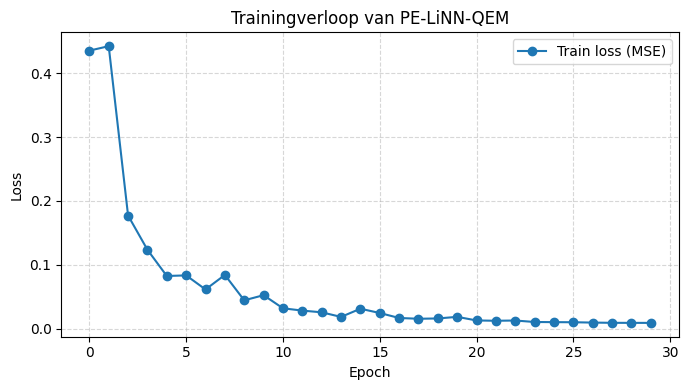

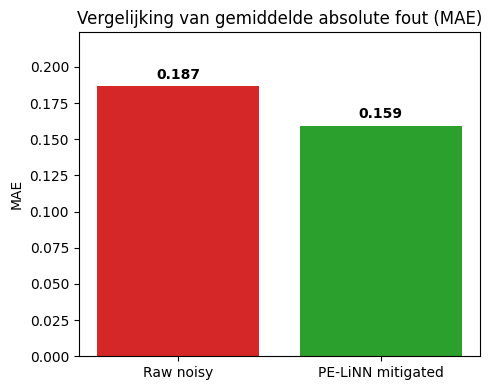

In [3]:
import matplotlib.pyplot as plt

# --- Plot settings ---
epochs = list(range(30))
losses = loss_out

raw_mae = raw_mae
mitigated_mae = mae

# --- Plot 1: training loss ---
plt.figure(figsize=(7,4))
plt.plot(epochs, losses, marker='o', label='Train loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trainingverloop van PE-LiNN-QEM")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: MAE-vergelijking ---
plt.figure(figsize=(5,4))
bars = ['Raw noisy', 'PE-LiNN mitigated']
values = [raw_mae, mitigated_mae]
colors = ['tab:red', 'tab:green']

plt.bar(bars, values, color=colors)
plt.ylabel("MAE")
plt.title("Vergelijking van gemiddelde absolute fout (MAE)")
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')
plt.ylim(0, max(values)*1.2)
plt.tight_layout()
plt.show()


In [4]:
# scripts/train_pelinn.py
import sys
# Allow notebooks to import project modules
from pathlib import Path

def _resolve_project_root():
    candidates = []
    try:
        candidates.append(Path.cwd().resolve())
    except FileNotFoundError:
        candidates.append(None)
    if "__file__" in globals():
        candidates.append(Path(__file__).resolve().parent)
    candidates.append(Path("/home/bram/work/PE-LiNN/pelinn-qem"))

    for base in candidates:
        if base is None:
            continue
        if (base / "pelinn").exists():
            return base
        parent = base.parent
        if (parent / "pelinn").exists():
            return parent
    return candidates[-1]

project_root = _resolve_project_root()
if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
import torch, numpy as np, random
from torch.utils.data import Dataset, DataLoader
from pelinn.data.qiskit_dataset import synthesize_samples
from pelinn.model import PELiNNQEM, physics_loss

if ("circuits" not in globals()) or ("observables" not in globals()):
    from qiskit import QuantumCircuit
    from qiskit.quantum_info import SparsePauliOp

    def _default_circuit_family(n=4, m=24):
        cs, obs = [], []
        for _ in range(m):
            qc = QuantumCircuit(n)
            for q in range(n): qc.h(q)
            for q in range(0, n - 1, 2): qc.cx(q, q + 1)
            qc.measure_all(False)  # keep state for estimators
            cs.append(qc)
            obs.append(SparsePauliOp.from_list([("Z" + "I" * (n - 1), 1.0)]))
        return cs, obs

    circuits, observables = _default_circuit_family()

if "noise_grid" not in globals():
    noise_grid = [
        {"p1_depol": 0.001, "p2_depol": 0.01, "p_amp": 0.001, "readout_p01": 0.02, "readout_p10": 0.02},
        {"p1_depol": 0.003, "p2_depol": 0.02, "p_amp": 0.002, "readout_p01": 0.03, "readout_p10": 0.03},
    ]

class QemDataset(Dataset):
    def __init__(self, samples):
        self.X = np.stack([s.x for s in samples]).astype(np.float32)
        self.y = np.array([s.y_ideal for s in samples], dtype=np.float32)
        self.cid = np.array([id(s.meta["qc"]) for s in samples], dtype=np.int64)  # circuit id for grouping
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i], self.cid[i]

def make_groups(cids):
    # group indices sharing the same circuit id
    groups = {}
    for i, c in enumerate(cids): groups.setdefault(int(c), []).append(i)
    return list(groups.values())

def train(model, loader, opt, device="cpu"):
    model.train()
    for X, y, cid in loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        groups = make_groups(cid.tolist())
        loss = physics_loss(pred, y, groups, alpha_inv=0.1)
        opt.zero_grad(); loss.backward(); opt.step()

# usage sketch
def synthesize_training_samples(circuits, observables, noise_grid):
    return synthesize_samples(circuits, observables, noise_grid)

required_symbols = ("circuits", "observables", "noise_grid")
_missing = [name for name in required_symbols if name not in globals()]
if _missing:
    samples = []
    print(f"Missing variables required to synthesize training data: {', '.join(_missing)}")
else:
    samples = synthesize_training_samples(circuits, observables, noise_grid)
# ds = QemDataset(samples); dl = DataLoader(ds, batch_size=128, shuffle=True)
# model = PELiNNQEM(in_dim=ds.X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
# opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
# for epoch in range(100): train(model, dl, opt)


In [5]:
ds = QemDataset(samples); dl = DataLoader(ds, batch_size=128, shuffle=True)
model = PELiNNQEM(in_dim=ds.X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
for epoch in range(100): train(model, dl, opt)


In [6]:
epoch

99